# Von Karman beam around the buckled state


We are using the Taylor coefficients extracted via SSMTool using the graph style parametrization. 

In [9]:
import numpy as np
from scipy.io import loadmat

In [10]:
import matplotlib.pyplot as plt

In [11]:
from taylor_to_pade.matlab_integration import *
from taylor_to_pade.approximant import TaylorSeries, PadeApproximant

In [12]:
import distinctipy

In [ ]:
colors = distinctipy.get_colors(10,
                                n_attempts = 3000,
                                rng = 16,
                                pastel_factor = 0,
                                colorblind_type = 'Protanomaly')


## Define the helper functions to extract Matlab coefficients

In [14]:
def get_coeff(expr):
    return expr.as_terms()[0][0][1][0][0] + 1j*expr.as_terms()[0][0][1][0][1]

In [15]:
def discard_small_coeffs(expr, tolerance = 1e-15):
    terms = sy.Add.make_args(expr)
    newexpr = 0
    for t in terms:
        if np.abs(get_coeff(t)) > tolerance:
            newexpr += t
    return newexpr

In [16]:
def discard_small_coeffs_pade(paded, tolerance = 1e-15):
    num, denom = paded.as_numer_denom()
    num = discard_small_coeffs(num, tolerance)
    denom = discard_small_coeffs(denom, tolerance)
    return num / denom

In [17]:
def generate_parametrization(list_param, order_num=3, order_denom=3, use_robust = False):
    parametrization_pade = []
    for p in list_param:
        pad = taylor_to_pade.approximant.PadeApproximant(order_numerator=order_num,
                                                         order_denominator=order_denom,
                                                         base = [p1, p2])
        pad.initialize_from_taylor(p.coefficients, use_robust = use_robust)
        parametrization_pade.append(pad)
    return parametrization_pade

In [18]:
def discard_small_coeffs(expr, tolerance = 1e-15):
    terms = sy.Add.make_args(expr)
    newexpr = 0
    for t in terms:
        if np.abs(get_coeff(t)) > tolerance:
            newexpr += t
    return newexpr

In [19]:
def discard_small_coeffs_pade(paded, tolerance = 1e-15):
    num, denom = paded.as_numer_denom()
    num = discard_small_coeffs(num, tolerance)
    denom = discard_small_coeffs(denom, tolerance)
    return num / denom

In [20]:
def return_parametrization_up_to_order_Taylor(parametrization_expressions, max_order = 30):
    parametrization = []
    for p in parametrization_expressions:
        coeff = taylor_to_pade.matlab_integration.extract_coefficients(p[0], [p1, p2], max_order)
        parametrization.append(TaylorSeries(coeff, max_order, base = [p1, p2]))
    return parametrization

In [21]:
def return_reduced_dyn_up_to_order_Taylor(reduced_dynamics_expressions, max_order = 30):
    red_dynamics = []
    for r in reduced_dynamics_expressions:
        coeff = taylor_to_pade.matlab_integration.extract_coefficients(r[0], [p1, p2], max_order)
        red_dynamics.append(TaylorSeries(coeff, max_order, base = [p1, p2]))
    for r in red_dynamics:
        r.polynomial = discard_small_coeffs(r.polynomial, tolerance = 1e-10)
    radial_variables, angle_variables, r_equations, phi_equations = taylor_to_pade.utils.convert_to_polar([p1, p2], [r.polynomial for r in red_dynamics])
    
    coeff = taylor_to_pade.matlab_integration.extract_coefficients_1d(phi_equations[0], radial_variables, max_order)
    frequency_Taylor = TaylorSeries(coeff, max_order, base = radial_variables)
    coeff = taylor_to_pade.matlab_integration.extract_coefficients_1d(r_equations[0], radial_variables, max_order)
    damping_Taylor = TaylorSeries(coeff, max_order, base = radial_variables)
    damping_curve_taylor_ = sy.lambdify(radial_variables[0], -r_equations[0]/radial_variables[0], 'numpy')
    damping_curve_taylor = lambda x : np.real(damping_curve_taylor_(x))
    return red_dynamics, frequency_Taylor, damping_Taylor, damping_curve_taylor, radial_variables, angle_variables#, r_equations, phi_equations

In [22]:
def reduced_dynamics(frequency, damping, order_num = 3, order_denom = 3, use_robust = False):
    frequency_Pade = PadeApproximant(order_denominator=order_num, order_numerator=order_num, base = radial_variables)
    damping_Pade = PadeApproximant(order_denominator=order_num, order_numerator=order_num, base = radial_variables)
    damping_Pade.initialize_from_taylor(damping.coefficients, use_robust = use_robust)
    frequency_Pade.initialize_from_taylor(frequency.coefficients, use_robust = use_robust)
    return frequency_Pade, damping_Pade

## Load SSM coefficients

In [23]:
import numpy as np
from scipy.io import loadmat
mat = loadmat('vonkarman_buckled_order18.mat')


In [24]:
import sympy as sy
p1, p2 = sy.symbols('p_1 p_2')
var = np.array([p1,p2]).reshape(-1,1)

In [25]:
%load_ext autoreload
%autoreload 2
%aimport taylor_to_pade


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import taylor_to_pade

In [27]:
mat['W_0'] = mat['W0']
mat['R_0'] = mat['R0']
del mat['R0']
del mat['W0']

In [28]:
def unpack_it(variables, coeff, exps):
    p1, p2 = variables
    val = 0
    for ex, cc in zip(exps,coeff):
        val += cc * p1**ex[0] * p2 ** ex[1]
    return val

In [29]:
matt = mat['W_0'][0]
W0 = taylor_to_pade.matlab_integration.extract_gen_new(mat, 'W_0') # get reduced dyn
parametrization_expressions = reduced_to_full(var, W0)

In [30]:
outdof = 34

In [31]:
parametrization_expressions = [parametrization_expressions[outdof],
            parametrization_expressions[17],
            parametrization_expressions[18]]

In [32]:
R0 = taylor_to_pade.matlab_integration.extract_gen_new(mat, 'R_0') # get reduced dyn
reduced_dynamics_expressions = taylor_to_pade.matlab_integration.reduced_to_full(var, R0)

In [33]:
def get_resp_at_r(r, idx):
    phi_sample = np.linspace(0, 2*np.pi, 100)
    z1 = r * np.exp(1j*phi_sample)
    zz = np.vstack((z1, np.conjugate(z1))).reshape(2,-1)
    response_taylor = np.real(parametrization[idx].evaluate(zz.T))
    return np.max(np.abs(response_taylor))

In [34]:
sample_rs = np.linspace(1e-7, 1e-3, 1000)

In [35]:
orders = np.arange(3, 10, 1)


### Extract the Taylor series

In [71]:
parametrization_18 = return_parametrization_up_to_order_Taylor(parametrization_expressions,
                                                            max_order = 18)
red_dynamics_18 = return_parametrization_up_to_order_Taylor(reduced_dynamics_expressions,max_order = 18)
                                                                                                                     



## Visualize the reduced dynamics:

In [744]:
xx = np.linspace(-1e-1, 1e-1, 100)

XX, YY = np.meshgrid(xx, xx)


In [745]:
pts = np.vstack((XX.ravel(), YY.ravel())).T

In [746]:
parametrization_pade = generate_parametrization(parametrization_18,
                                                order_num = 3,
                                                order_denom = 3,
                                                use_robust = True)


In [747]:
UU = red_dynamics_18[0].evaluate(pts).reshape(XX.shape)
VV = red_dynamics_18[1].evaluate(pts).reshape(XX.shape)
zz = parametrization_18[0].evaluate(pts).reshape(XX.shape)
zz_pade = parametrization_pade[0].evaluate(pts).reshape(XX.shape)


(-0.1, 0.1)

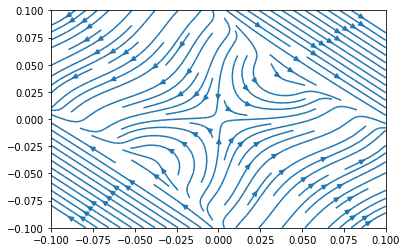

In [749]:
plt.streamplot(XX, YY, UU, VV)
plt.xlim(xx.min(), xx.max())
plt.ylim(xx.min(), xx.max())


In [751]:
red_dyn_pade = generate_parametrization(red_dynamics_18, order_num = 6, order_denom = 6, use_robust = True)


In [752]:
xx = np.linspace(-1e-1, 1e-1, 100)

XX, YY = np.meshgrid(xx, xx)


In [753]:
pts = np.vstack((XX.ravel(), YY.ravel())).T

In [754]:
UU = red_dyn_pade[0].evaluate(pts).reshape(XX.shape)
VV = red_dyn_pade[1].evaluate(pts).reshape(XX.shape)

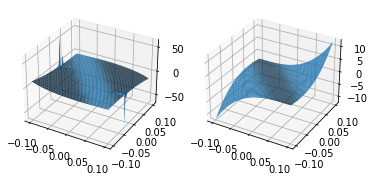

In [755]:
fig = plt.figure()
ax = fig.add_subplot(121, projection = '3d')
ax2 = fig.add_subplot(122, projection = '3d')
#ax.plot_surface(TT1, TT2, pad_18_ro)
#ax.plot_surface(TT1, TT2, pad_9)
ax.plot_surface(XX, YY, UU)
ax2.plot_surface(XX, YY, VV)

(-0.1, 0.1)

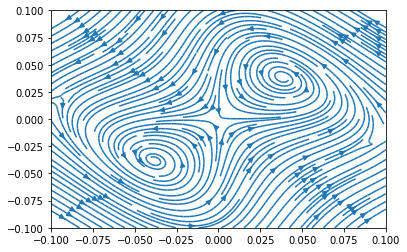

In [757]:
plt.streamplot(XX, YY, UU, VV, density = 2)
plt.xlim(xx.min(), xx.max())
plt.ylim(xx.min(), xx.max())


## Load the unforced data

In [758]:
dat = loadmat('dataVK_buckled_unforced_mid.mat')

In [759]:
W_1 = W0[0]['coeffs']

$$
\xi w_1 = \omega $$

In [760]:
plus_ = dat['sol_plus']- dat['unstable_fp'].T
minus_ = dat['sol_minus'] - dat['unstable_fp'].T


In [763]:
reduced_plus = np.linalg.lstsq(W_1, plus_.T)[0]
reduced_minus = np.linalg.lstsq(W_1, minus_.T)[0]


/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_58706/3020135435.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  reduced_plus = np.linalg.lstsq(W_1, plus_.T)[0]
/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_58706/3020135435.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  reduced_minus = np.linalg.lstsq(W_1, minus_.T)[0]


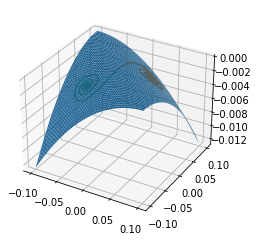

In [764]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
#ax.plot_surface(TT1, TT2, pad_18_ro)
#ax.plot_surface(TT1, TT2, pad_9)
ax.plot_surface(XX, YY, zz_pade)
ax.plot(reduced_plus[0,:], reduced_plus[1,:], plus_[:,outdof])
ax.plot(reduced_minus[0,:], reduced_minus[1,:], minus_[:,outdof])

In [1099]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 13, "font.family": "serif",})
plt.rcParams.update({'text.latex.preamble':r"\usepackage{amsmath}"})

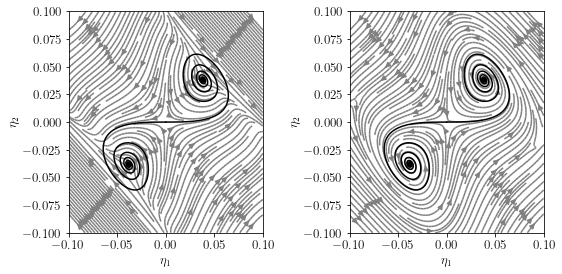

In [1162]:
ff = plt.figure(figsize = (8, 4))
ax = ff.add_subplot(121)
ax2 = ff.add_subplot(122)
UU = red_dynamics_18[0].evaluate(pts).reshape(XX.shape)
VV = red_dynamics_18[1].evaluate(pts).reshape(XX.shape)
streamplotobject_taylor = ax.streamplot(XX, YY, UU, VV, density = 2, color='grey')
ax.plot(reduced_plus[1,:], reduced_plus[0,:], c= 'black')
ax.plot(reduced_minus[1,:], reduced_minus[0,:], c= 'black')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(xx.min(), xx.max())

UU = red_dyn_pade[0].evaluate(pts).reshape(XX.shape)
VV = red_dyn_pade[1].evaluate(pts).reshape(XX.shape)

streamplotobject_pade = ax2.streamplot(XX, YY, UU, VV, density = 2, color='grey')
ax2.plot(reduced_plus[1,:], reduced_plus[0,:] , c= 'black')
ax2.plot(reduced_minus[1,:], reduced_minus[0,:], c= 'black')
ax2.set_xlim(xx.min(), xx.max())
ax2.set_ylim(xx.min(), xx.max())
ax.set_xlabel('$\eta_1$')
ax2.set_xlabel('$\eta_1$')
ax.set_ylabel('$\eta_2$')
ax2.set_ylabel('$\eta_2$')
plt.tight_layout()


In [1247]:
ic_plus_reduced = reduced_plus[:,0][::-1]
ic_minus_reduced = reduced_minus[:,0][::-1]


In [1248]:
def odeint_pade(t, x):
    return np.array([red_dyn_pade[0].evaluate(x.reshape(1,-1)),
                   red_dyn_pade[1].evaluate(x.reshape(1,-1))]).ravel()

def odeint_tay(t, x):
    return np.array([red_dynamics_18[0].evaluate(x.reshape(1,-1)),
                   red_dynamics_18[1].evaluate(x.reshape(1,-1))]).ravel()

In [1267]:
sy.Matrix([r.polynomial for r in red_dynamics_18]).jacobian([p1,p2]).subs([(p1, 0), (p2,0)])

Matrix([
[23.4842291125072,                 0],
[               0, -23.5294698288897]])

In [1300]:
coeffs_poly_1 = dict(red_dynamics_18[0].polynomial.as_coefficients_dict())
coeffs_poly_2 = dict(red_dynamics_18[1].polynomial.as_coefficients_dict())

In [1249]:
from scipy.integrate import solve_ivp

In [ ]:
teval = np.linspace(0, 2, 2000)
sol_plus_pade = solve_ivp(odeint_pade, [0,2], ic_plus_reduced, t_eval = teval, method = 'DOP853')
sol_minus_pade = solve_ivp(odeint_pade, [0,2], ic_minus_reduced, t_eval = teval, method = 'DOP853')


sol_plus_taylor = solve_ivp(odeint_tay, [0,2], ic_plus_reduced, t_eval = teval, method = 'DOP853')
sol_minus_taylor = solve_ivp(odeint_tay, [0,2], ic_minus_reduced, t_eval = teval, method = 'DOP853')


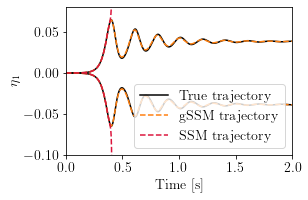

In [1899]:
ff = plt.figure(figsize = (4.5,3))
ax = ff.add_subplot(111)

ax.plot(teval, reduced_minus[1,:], '-', c='black', label = 'True trajectory')

ax.plot(sol_minus_pade.t, sol_minus_pade.y[0,:], '--', c='C1', label = 'gSSM trajectory')
ax.plot(sol_minus_taylor.t, sol_minus_taylor.y[0,:], '--', c='crimson', label = 'SSM trajectory')


ax.plot(teval, reduced_plus[1,:], '-', c='black')
ax.plot(sol_plus_pade.t, sol_plus_pade.y[0,:], '--', c='C1')
ax.plot(sol_plus_taylor.t, sol_plus_taylor.y[0,:], '--', c='crimson')

ax.set_xlabel('Time [s]')
ax.set_ylabel('$\eta_1$')
ax.set_ylim(-0.1, 0.08)
ax.set_xlim(0, 2)
ax.legend(loc='lower right', fontsize = 14.25)
plt.tight_layout()


## Chaotic forcing

In [1240]:
timescale = 2*np.pi/frq_
numberPeriods = 100
numberPointsPerPeriod = 100
endTime = numberPeriods*timescale;
nSamp = numberPeriods*numberPointsPerPeriod+1
dt = endTime/(nSamp-1);
timespan = np.linspace(0, endTime, nSamp)

First the Taylor dynamics:

In [ ]:
amp_ssm =  0.2267033242968807
amp_full = 21.1154
def odeint_pade_forced(t, x):
    phase = frq_ * t
    autonomous = np.array([red_dyn_pade[0].evaluate(x.reshape(1,-1)),
                   red_dyn_pade[1].evaluate(x.reshape(1,-1))]).ravel()
    return autonomous + np.array([amp_ssm, -amp_ssm])*np.cos(frq_ * t)




In [1904]:
def odeint_taylor_forced(t, x):
    autonomous = np.array([red_dynamics_18[0].evaluate(x.reshape(1,-1)),
                   red_dynamics_18[1].evaluate(x.reshape(1,-1))]).ravel()
    return autonomous + np.array([amp_ssm, -amp_ssm]) * np.cos(frq_ * t)
timescale = 2*np.pi/frq_
numberPeriods = 200
numberPointsPerPeriod = 100
endTime = numberPeriods*timescale;
nSamp = numberPeriods*numberPointsPerPeriod+1
dt = endTime/(nSamp-1);
timespan = np.arange(0, endTime, dt)

In [1210]:
sol_chaotic_taylor_1 = solve_ivp(odeint_taylor_forced, [0,endTime], ic1, t_eval = timespan, method = 'DOP853', rtol = 1e-12)
sol_chaotic_taylor_2 = solve_ivp(odeint_taylor_forced, [0,endTime], ic2, t_eval = timespan, method = 'DOP853', rtol = 1e-12)

In [1218]:
midpoint_pade_chaot_1 = parametrization_pade[0].evaluate(sol_1_pade.y.T)
midpoint_taylor_chaot_1 = parametrization_18[0].evaluate(sol_chaotic_taylor_1.y.T)


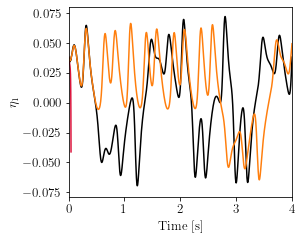

In [1638]:
ff = plt.figure(figsize = (4,3.5))
ax = ff.add_subplot(111)

ax.plot(sol_1_pade.t, reduced_traj1[0,:], '-', c='black', label = 'True trajectory')
ax.plot(sol_chaotic_taylor_1.t, sol_chaotic_taylor_1.y[1,:], '-', c='crimson', label = 'Reduced trajectory (Taylor)')
ax.plot(sol_1_pade.t, sol_1_pade.y[1,:], '-', c='C1')
ax.set_xlim(0, 4)
ax.set_xlabel('Time [s]')
ax.set_ylabel('$\eta_1$')
